In [1]:
import sys

In [2]:
from nutil import *

In [3]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve

In [4]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [5]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set

        n,d = X.shape

        prob_dict = {}
        for i in Counter(y).items():
            prob_dict[i[0]] = i[1] / n

        self.probabilities_ = prob_dict

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        n,d = X.shape

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        y = np.random.choice(list(self.probabilities_.keys()), size = n, p=list(self.probabilities_.values()))

        ### ========== TODO : END ========== ###

        return y


In [6]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [7]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.15) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        val_error  -- float, validation error
        f1_score    -- float, validation "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # part f:
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use StratifiedShuffleSplit (be careful of the parameters)

    train_errors = []
    val_errors = []
    f1_scores = []

    splitter = StratifiedShuffleSplit(n_splits = ntrials, test_size = test_size, random_state = 0)

    for train_index, test_index in splitter.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        train_errors.append(1 - np.mean(y_train_pred == y_train))
        y_test_pred = clf.predict(X_test)
        val_errors.append(1 - np.mean(y_test_pred == y_test))
        f1 = metrics.f1_score(y_test, y_test_pred, average='micro')
        f1_scores.append(f1)

    train_error = np.mean(train_errors)
    val_error = np.mean(val_errors)
    f1_score = np.mean(f1_scores)

    ### ========== TODO : END ========== ###

    return train_error, val_error, f1_score




In [8]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


In [9]:
######################################################################
# main
######################################################################

# load adult_subsample dataset with correct file path

### ========== TODO : START ========== ###
# for example data_file =  "/content/drive/My Drive/cs146/hw1/adult_subsample.csv"
data_file = "./adult_subsample.csv"
### ========== TODO : END ========== ###

data = load_data(data_file, header=1, predict_col=-1)

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features


Plotting...


<Figure size 432x288 with 0 Axes>

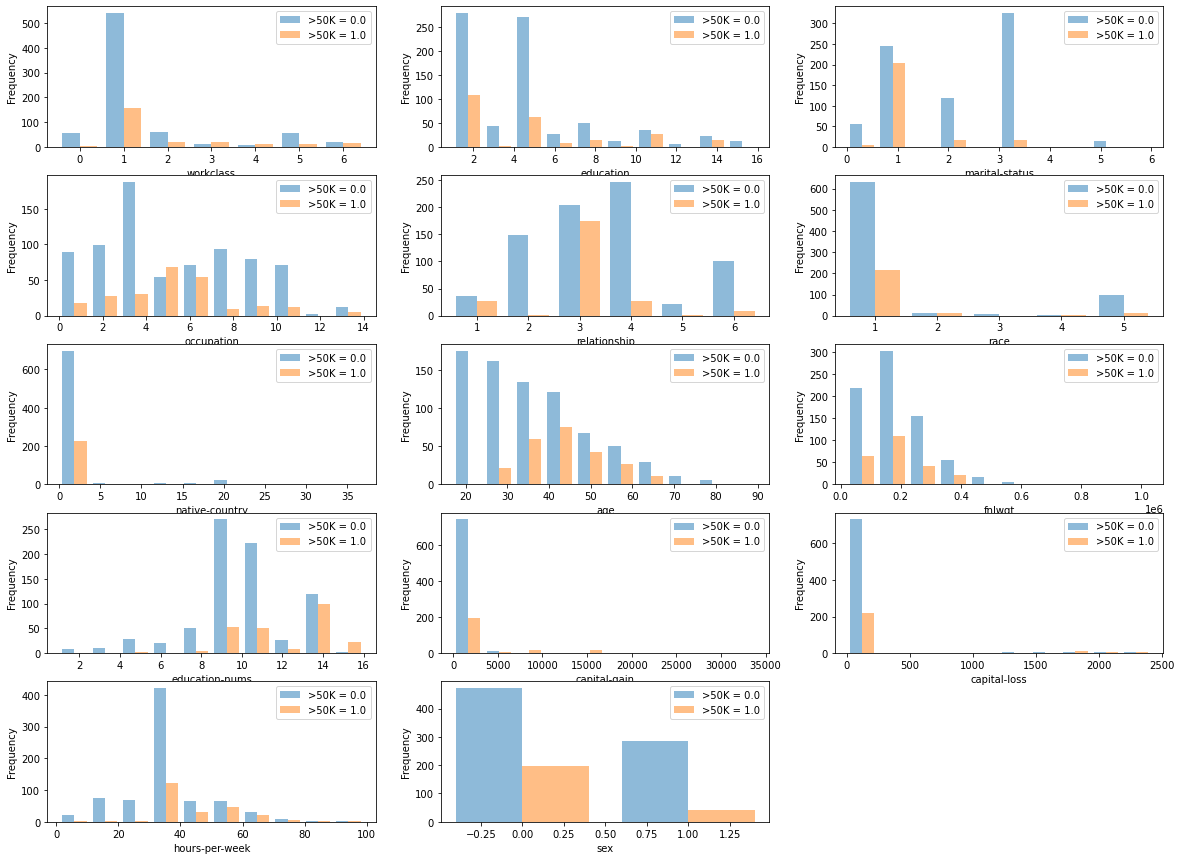

In [10]:
plt.figure()
#========================================
# part a: plot histograms of each feature
print('Plotting...')
plot_histograms (X, y, Xnames=Xnames, yname=yname)

In [11]:
#========================================
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Majority Vote...
	-- training error: 0.240


In [12]:
### ========== TODO : START ========== ###
# part b: evaluate training error of Random classifier
print('Classifying using Random...')
rd = RandomClassifier()       # create Random classifier, which includes all model parameters
rd.fit(X, y)                  # fit training data using the classifier
y_pred = rd.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)
### ========== TODO : END ========== ###

Classifying using Random...
	-- training error: 0.385


In [13]:
### ========== TODO : START ========== ###
# part c: evaluate training error of Decision Tree classifier
print('Classifying using Decision Tree...')
dt = DecisionTreeClassifier(criterion = 'entropy')
dt.fit(X, y)
y_pred = dt.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)
### ========== TODO : END ========== ###

Classifying using Decision Tree...
	-- training error: 0.000


In [14]:
### ========== TODO : START ========== ###
# part d: evaluate training error of k-Nearest Neighbors classifier
# use k = 3, 5, 7 for n_neighbors
print('Classifying using KNN, with K = 3...')
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn3.fit(X, y)
y_pred = knn3.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f\n' % train_error)

print('Classifying using KNN, with K = 5...')
knn5 = KNeighborsClassifier(n_neighbors = 5)
knn5.fit(X, y)
y_pred = knn5.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f\n' % train_error)

print('Classifying using KNN, with K = 7...')
knn7 = KNeighborsClassifier(n_neighbors = 7)
knn7.fit(X, y)
y_pred = knn7.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f\n' % train_error)
### ========== TODO : END ========== ###

Classifying using KNN, with K = 3...
	-- training error: 0.153

Classifying using KNN, with K = 5...
	-- training error: 0.195

Classifying using KNN, with K = 7...
	-- training error: 0.213



In [15]:
### ========== TODO : START ========== ###
# part e: evaluate training error of Logistic Regression
# use lambda_ = 0.1, 1, 10 for n_neighbors
# Note: Make sure you initialize your classifier with the appropriate parameters: 
# random_state=0 and max_iter=1000, using the default solver is fine.
print('Classifying using Logistic Regression, with lambda = 0.1...')
lr1 = LogisticRegression(C = 10, random_state = 0, max_iter = 1000)
lr1.fit(X, y)
y_pred = lr1.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f\n' % train_error)

print('Classifying using Logistic Regression, with lambda = 1...')
lr2 = LogisticRegression(C = 1, random_state = 0, max_iter = 1000)
lr2.fit(X, y)
y_pred = lr2.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f\n' % train_error)

print('Classifying using Logistic Regression, with lambda = 10...')
lr3 = LogisticRegression(C = 0.1, random_state = 0, max_iter = 1000)
lr3.fit(X, y)
y_pred = lr3.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f\n' % train_error)
### ========== TODO : END ========== ###

Classifying using Logistic Regression, with lambda = 0.1...
	-- training error: 0.208

Classifying using Logistic Regression, with lambda = 1...
	-- training error: 0.208

Classifying using Logistic Regression, with lambda = 10...
	-- training error: 0.213



In [16]:
### ========== TODO : START ========== ###
# part f: use cross-validation to compute average training and validation error of classifiers
print('Investigating various classifiers...\n')
print()
print('Classifying using Random...')
avg_train_error_rc, avg_validation_error_rc, avg_f1_score_rc = error(clf, X, y)
print('average training error for Random Classifier:', avg_train_error_rc)
print('average validation error for Random Classifier:', avg_validation_error_rc)
print('average f1 score for Random Classifier:', avg_f1_score_rc)
print()
print('Classifying using Decision Tree...')
avg_train_error_dt, avg_validation_error_dt, avg_f1_score_dt = error(dt, X, y)
print('average training error for Decision Tree:', avg_train_error_dt)
print('average validation error for Decision Tree:', avg_validation_error_dt)
print('average f1 score for Decision Tree:', avg_f1_score_dt)
print()
print('Classifying using KNN...')
avg_train_error_knn, avg_validation_error_knn, avg_f1_score_knn = error(knn5, X, y)
print('average training error for KNN:', avg_train_error_knn)
print('average validation error for KNN:', avg_validation_error_knn)
print('average f1 score for KNN:', avg_f1_score_knn)
print()
print('Classifying using Linear Regression...')
avg_train_error_lr, avg_validation_error_lr, avg_f1_score_lr = error(lr2, X, y)
print('average training error for Logistic Regression:', avg_train_error_lr)
print('average validation error for Logistic Regression:', avg_validation_error_lr)
print('average f1 score of Logistic Regression:', avg_f1_score_lr)

### ========== TODO : END ========== ###

Investigating various classifiers...


Classifying using Random...
average training error for Random Classifier: 0.24
average validation error for Random Classifier: 0.24
average f1 score for Random Classifier: 0.7600000000000001

Classifying using Decision Tree...


average training error for Decision Tree: 0.0
average validation error for Decision Tree: 0.20133333333333334
average f1 score for Decision Tree: 0.7986666666666666

Classifying using KNN...
average training error for KNN: 0.19977647058823528
average validation error for KNN: 0.2544
average f1 score for KNN: 0.7455999999999999

Classifying using Linear Regression...
average training error for Logistic Regression: 0.20842352941176467
average validation error for Logistic Regression: 0.21346666666666664
average f1 score of Logistic Regression: 0.7865333333333332


Finding the best k...


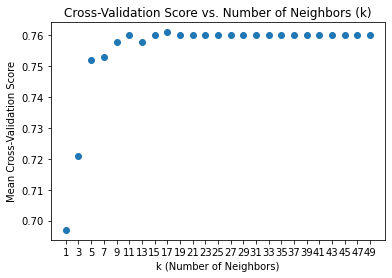

Best value of k: 17
Corresponding mean cross-validation score: 0.761


In [17]:
### ========== TODO : START ========== ###
# part g: use 5-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
print('Finding the best k...')
best_k = None
best_score = -1
k_values = range(1, 51, 2)
mean_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X, y, cv=5)
    mean_score = np.mean(scores)
    mean_scores.append(mean_score)
    if mean_score > best_score:
        best_k = k
        best_score = mean_score
plt.scatter(k_values, mean_scores)
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Cross-Validation Score')
plt.title('Cross-Validation Score vs. Number of Neighbors (k)')
plt.xticks(k_values)
plt.show()

print(f"Best value of k: {best_k}")
print(f"Corresponding mean cross-validation score: {best_score:.3f}")
### ========== TODO : END ========== ###

Investigating depths...


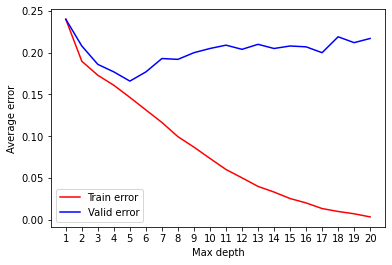

In [18]:
### ========== TODO : START ========== ###
# part h: investigate decision tree classifier with various depths
print('Investigating depths...')

max_depths = range(1, 21)
train_errors = []
valid_errors = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_validate(dt, X, y, cv=5, return_train_score=True)
    train_error = 1 - np.mean(scores['train_score'])
    valid_error = 1 - np.mean(scores['test_score'])
    train_errors.append(train_error)
    valid_errors.append(valid_error)
plt.plot(train_errors, color='red', label='Train error')
plt.plot(valid_errors, color='blue', label='Valid error')
plt.xlabel('Max depth')
plt.ylabel('Average error')
plt.xticks(np.arange(0, 20), [str(i + 1) for i in range(20)])
plt.legend()
plt.show()

### ========== TODO : END ========== ###

In [19]:
print('Done')

Done
